# [Title]

## Preparation

- [Github link](google.com) *[Optional]*

- Number of words: ***

- Runtime: *** hours (*Memory 10 GB, CPU Intel i7-10700 CPU @2.90GHz*)

- Coding environment: SDS Docker

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.
 
    - To install required package:  
    ```bash  
    !pip install linearmodels  
    ```
    ```bash
    !pip install nbconvert weasyprint  
    ```
    

## Table of contents

1. [Introduction](#Introduction)

2. [Literature Review](#Literature-Review)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## 1. Introduction

[[ go back to the top ]](#Table-of-contents)

Childhood obesity remains a critical public health challenge in London, adversely affecting children's health and causing significant economic costs. To address this, the UK government's *Childhood Obesity: A Plan for Action* (Department of Health and Social Care, 2018) substantially expanded investments in physical activity infrastructure, including funding for school sports and community facilities. Public Health England's *Local Health Profiles* report increased availability of parks, playgrounds, and sports centres across London wards ([Public Health England, 2023](#phe-2023)). Nonetheless, reductions in childhood obesity have been limited and uneven, especially among younger children, underscoring obesity's multifactorial nature and insufficient impact from infrastructure expansion alone ([Wyszyńska et al., 2020](#wyszynska-2020); [Lieb, 2009](#lieb-2009)).  

This study aims to quantitatively evaluate how different facility types influence childhood obesity rates across age groups in London wards from 2009/10 to 2013/14. It also examines the moderating roles of socioeconomic status (SES), green space, and public transport accessibility (PTAL). Leveraging spatial and temporal fixed effects, this research seeks to uncover spatial heterogeneity and construct a novel risk-intervention two-dimensional quadrant framework combining spatial fixed effects and residuals to guide targeted, equitable public health interventions.

### Requirements to Run the Analysis  
 An overview of packages used to run the analysis with brief explanation of their role.

In [1]:
!pip install linearmodels  
!pip install nbconvert weasyprint  

In [2]:
import os  
import requests  
import zipfile  
from functools import reduce  

import pandas as pd  
import geopandas as gpd  
from shapely.geometry import Point  

import numpy as np  
import scipy.stats as stats  

import matplotlib.pyplot as plt  
from matplotlib.gridspec import GridSpec  

import seaborn as sns  

from sklearn.ensemble import RandomForestRegressor  
from sklearn.preprocessing import StandardScaler  

import statsmodels.api as sm  
import statsmodels.formula.api as smf  
from statsmodels.iolib.summary2 import summary_col  
from statsmodels.stats.outliers_influence import variance_inflation_factor  

from linearmodels.panel import PanelOLS  

import nbformat  
import nbconvert  
from nbconvert.exporters import HTMLExporter  
from nbconvert.preprocessors import Preprocessor  
from weasyprint import HTML, CSS  

## 2. Literature Review

[[ go back to the top ]](#Table-of-contents)

Increasing evidence challenges the notion that expanding physical activity facilities alone suffices to reduce childhood obesity rates. While infrastructure is necessary, obesity results from complex interactions among behaviours, socioeconomic factors, and environmental contexts ([Danielli et al., 2021](#danielli-2021)). Research shows age influences intervention responses: older children engage more independently with their surroundings, whereas younger children's behaviours are more shaped by familial and cultural factors ([Wyszyńska et al., 2020](#wyszynska-2020); [Ayala et al., 2021](#ayala-2021)), indicating the need for age-specific approaches.  

Socioeconomic disparities exacerbate risk, as children from lower SES backgrounds often face poor access to quality facilities and supportive environments ([Lieb et al., 2009](#lieb-2009); [Yuan, 2024](#yuan-2024)). Environmental factors such as green space and public transport accessibility further modify physical activity opportunities and obesity outcomes ([Danielli et al., 2021](#danielli-2021)). Additionally, spatial heterogeneity within London wards manifests uneven obesity prevalence and resources, warranting geographically targeted interventions ([Titis et al., 2023](#titis-2023)).  

Notably, [Nau et al. (2019)](#nau-2019) used panel data integrating socioeconomic and built environment factors to study youth BMI trajectories across diverse communities, emphasizing the importance of accounting for spatial and temporal heterogeneity and dynamic interactions over time in obesity research.

Building on these foundations, the present study integrates facility types, age groups, SES, and environmental factors within a spatial-temporal fixed effects framework. This approach aims to better capture how facility impacts vary by age and SES while precisely modeling spatial heterogeneity in childhood obesity patterns, thereby informing more nuanced, targeted interventions.

## 3. Research questions

[[ go back to the top ]](#Table-of-contents)

Building on the above, and given that facility effects vary by children’s development and socioeconomic access, while environmental factors (SES, greenspace, PTAL) may modify these effects through space and time, this study addresses:

- **RQ1 |** How do different facility types affect childhood obesity across age and socioeconomic groups, after accounting for spatial and temporal factors?

- **RQ2 |** How do greenspace and public transport accessibility modify the effects of facilities on obesity?

Recognizing that obesity prevalence and environmental influences vary across geographic areas and over time, a comprehensive spatial-temporal analysis is necessary. Consequently:  

- **RQ3 |** How can spatial and temporal fixed effects reveal heterogeneous patterns to inform targeted public health interventions?


## 4. Data Collection

[[ go back to the top ]](#Table-of-contents)

This study focuses on London wards at the 2011 level ([London Data Store, 2011](#lds-boundary)), offering the finest publicly available spatial resolution. The research covers the academic years from 2010/2011 to 2013/2014, spanning four academic years in total.  

Zip file already exists. Skipping download.
Found existing shapefile at: data/London-wards-2014/London-wards-2014 (1)/London-wards-2014_ESRI/London_Ward.shp
Shapefile already extracted at: data/London-wards-2014/London-wards-2014 (1)/London-wards-2014_ESRI/London_Ward.shp
Loading the shapefile...
                     NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0       Chessington South  E05000405   755.173         0.0  E09000021   
1  Tolworth and Hook Rise  E05000414   259.464         0.0  E09000021   
2              Berrylands  E05000401   145.390         0.0  E09000021   
3               Alexandra  E05000400   268.506         0.0  E09000021   
4                Beverley  E05000402   187.821         0.0  E09000021   

                BOROUGH  POLY_ID  \
0  Kingston upon Thames    50840   
1  Kingston upon Thames   117160   
2  Kingston upon Thames    50449   
3  Kingston upon Thames    50456   
4  Kingston upon Thames   117161   

                                            ge

/tmp/ipykernel_76522/711259404.py:57: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  facilities = pd.read_csv('data/GIS_Active_Places_Power_Facility_2339094778124018571.csv')
/tmp/ipykernel_76522/711259404.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  facilities['closed_date'] = pd.to_datetime(facilities['closed_date'], errors='coerce')
/tmp/ipykernel_76522/711259404.py:89: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...

  gdf_fac_london = gpd.sjoin(gdf_fac, wards, predicate='within', how='inner')


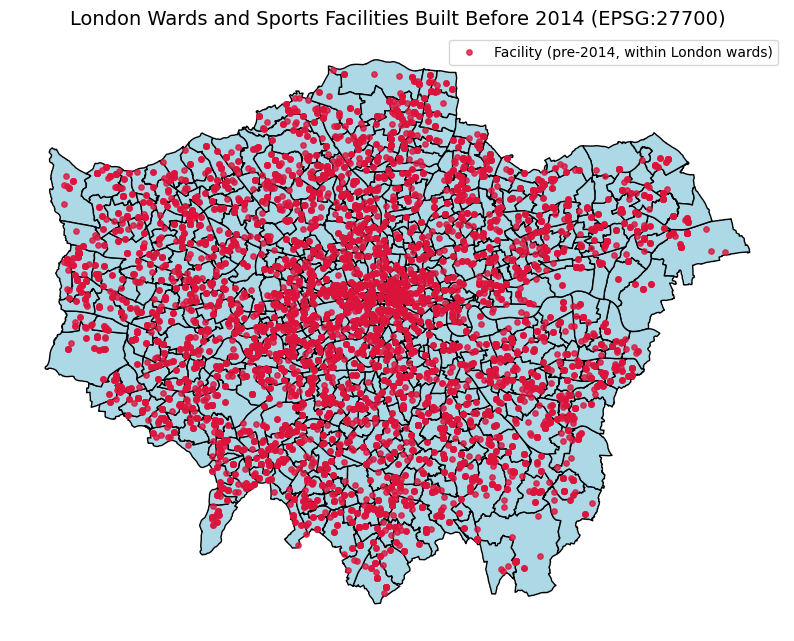

In [3]:
# 3.1 Import London-ward shapefile
url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/b381c92b-9120-45c6-b97e-0f7adc567dd2/London-wards-2014.zip"  
zip_path = "data/London-wards-2014.zip"  
extract_dir = "data/London-wards-2014"  

os.makedirs("data", exist_ok=True)  

# Download ZIP if necessary  
if not os.path.exists(zip_path):  
    print("Downloading zip file…")  
    resp = requests.get(url)  
    with open(zip_path, "wb") as f:  
        f.write(resp.content)  
else:  
    print("Zip file already exists. Skipping download.")  

# Extract ZIP if shapefile not already present  
need_extract = True  
if os.path.exists(extract_dir):  
    # Search for .shp file recursively  
    for root, dirs, files in os.walk(extract_dir):  
        for f in files:  
            if f.lower() == "london_ward.shp":  
                shp_path = os.path.join(root, f)  
                need_extract = False  
                print(f"Found existing shapefile at: {shp_path}")  
                break  
        if not need_extract:  
            break  

if need_extract:  
    print("Extracting zip file…")  
    with zipfile.ZipFile(zip_path, "r") as zip_ref:  
        zip_ref.extractall(extract_dir)  
    # Find .shp after extraction  
    shp_path = None  
    for root, dirs, files in os.walk(extract_dir):  
        for f in files:  
            if f.lower() == "london_ward.shp":  
                shp_path = os.path.join(root, f)  
                print(f"Shapefile extracted at: {shp_path}")  
                break  
        if shp_path:  
            break  
    if not shp_path:  
        raise FileNotFoundError("Shapefile not found after extraction!")  
else:  
    print(f"Shapefile already extracted at: {shp_path}")  

# Load shapefile with geopandas  
print("Loading the shapefile...")  
wards = gpd.read_file(shp_path)  
print(wards.head())  


# 3.2.1 Import and caculate Facilities data
facilities = pd.read_csv('data/GIS_Active_Places_Power_Facility_2339094778124018571.csv')  
facilities = facilities.rename(columns={  
    'Accessibility Type Group (Text)': 'access_group',  
    'Management Type Group (Text)': 'mgmt_group',  
    'Facility Type': 'facility_type',  
    'Year Built': 'year_built',  
    'Closed Date': 'closed_date',  
    'Latitude': 'lat',  
    'Longitude': 'lon'  
})  

# Select relevant columns  
facilities = facilities[['lat', 'lon', 'year_built', 'access_group', 'mgmt_group', 'facility_type', 'closed_date']]  

# Type conversion for filtering  
facilities['year_built'] = pd.to_numeric(facilities['year_built'], errors='coerce')  
facilities['closed_date'] = pd.to_datetime(facilities['closed_date'], errors='coerce')  

# Filter: built before 2014 and (not closed or closed in/after 2014)  
mask = (facilities['year_built'] < 2014) & (  
    facilities['closed_date'].isna() | (facilities['closed_date'].dt.year >= 2014)  
)  
facilities = facilities[mask]  

# Convert to GeoDataFrame (WGS84)  
geometry = [Point(xy) for xy in zip(facilities['lon'], facilities['lat'])]  
gdf_fac = gpd.GeoDataFrame(facilities, geometry=geometry, crs="EPSG:4326")  

# Reproject to EPSG:27700 to match wards  
gdf_fac = gdf_fac.to_crs(epsg=27700)  

# Clip facility points to London wards boundary (keep only points within wards)  
gdf_fac_london = gpd.sjoin(gdf_fac, wards, predicate='within', how='inner')  

# Plot: overlay points on wards map  
fig, ax = plt.subplots(figsize=(10, 10))  
wards.plot(ax=ax, color="lightblue", edgecolor="black")  
gdf_fac_london.plot(  
    ax=ax, color="crimson", markersize=15, label="Facility (pre-2014, within London wards)", alpha=0.8  
)  
ax.set_title("London Wards and Sports Facilities Built Before 2014 (EPSG:27700)", fontsize=14)  
ax.axis('off')  
plt.legend()  
plt.show()  


#3.2.2 Caculate Facilities per 10000 pop by wards
# Calculate Facilities per 10,000 Population by Wards  
years, pop_years = range(2010, 2015), [2011, 2012, 2013, 2014]  
facility_types = ['Education', 'Commercial', 'Local Authority']  
ward_cols = ['NAME', 'GSS_CODE', 'BOROUGH', 'geometry']  

**Table 3.1:** Variable Descriptions and Data Sources for Urban Childhood Obesity Analysis

| Variable Category | Variable Name | Description | Time Coverage | Data Source |  
|:-----------------|:--------------|:------------|:-------------|:------------|  
| **Obesity Rates** | `obese_recp` | Reception children obesity (ages 4-5) | 2010/2011–2013/2014 | [Ward Atlas-NCMP](#ward-profiles-atlas) |  
| | `obese_y6` | Year 6 children obesity (ages 10-11) | 2010/2011–2013/2014 | [Ward Atlas-NCMP](#ward-profiles-atlas) |  
| **Facility Types** | `facility_edu` | Education facilities per 10,000 pop | 2010–2014 | [Active Places](#active-places-power), [ONS](#ons-pop) |  
| | `facility_comm` | Commercial facilities per 10,000 pop | 2010–2014 | [Active Places](#active-places-power), [ONS](#ons-pop) |  
| | `facility_local` | Local authority facilities per 10,000 pop | 2010–2014 | [Active Places](#active-places-power), [ONS](#ons-pop) |  
| **Socioeconomic** | `unemp` | Unemployment rate | 2010–2014 | [Ward Profiles](#ward-profiles-atlas) |  
| **Environmental** | `greenspace_pct` | Percentage of greenspace | 2010, 2012* | [Ward Profiles](#ward-profiles-atlas) |  
| | `ptal` | Public Transport Accessibility Level | 2010, 2011, 2012, 2014* | [Ward Profiles](#ward-profiles-atlas) |  

*[Note: Missing years for greenspace and PTAL were estimated via interpolation as described below.]*

The key independent variables are densities of physical activity facilities, with the proportion of children from unemployed households and children’s age groups used as heterogeneity stratifiers; greenspace coverage and public transport accessibility (PTAL) are included as control variables.

1. Facilities were filtered to include only those operational before 2014 by considering their opening and closing dates. Population estimates for wards each year were taken from the Office for National Statistics ([ONS, 2023](#ons-pop)). Facility density per 10,000 population was calculated using the formula:  
<div style="text-align:center; padding:10px 0;">  
  <span style="font-family: 'Times New Roman', serif; font-size:1.1em; font-weight:bold;">  
    Facility density = (Number of operational facilities in ward &#x2215; Ward population) &times; 10,000  
  </span>  
</div>  

   This calculation standardises facility counts by population size, enabling meaningful comparison across wards with differing population numbers.  

In [4]:
# Count active facilities per ward per year  
def count_facilities_by_ward(gdf_fac_london, years, facility_types):  
    wards_fac_count = wards[ward_cols].copy()  
    for yr in years:  
        # Filter active facilities for the year  
        mask_active = (  
            (gdf_fac_london['year_built'] <= yr) &   
            (gdf_fac_london['closed_date'].isna() | (gdf_fac_london['closed_date'].dt.year >= yr))  
        )  
        active = gdf_fac_london[mask_active]  
        
        # Count facilities by type for each ward  
        for ftype in facility_types:  
            temp = active[active['mgmt_group'] == ftype]  
            by_ward = temp.groupby('GSS_CODE').size().rename(f'facility_{ftype.lower()}_{yr}').reset_index()  
            wards_fac_count = wards_fac_count.merge(by_ward, on='GSS_CODE', how='left')  
    
    # Fill missing values with 0  
    for ftype in facility_types:  
        for yr in years:  
            col = f'facility_{ftype.lower()}_{yr}'  
            if col in wards_fac_count.columns:  
                wards_fac_count[col] = wards_fac_count[col].fillna(0)  
    
    return wards_fac_count  

In [5]:
# Load and process population data  
def load_population_data(pop_years):  
    pop_files = [  
        'data/London_Population_wards/mid_2011_ward_2011_quinary.csv',  
        'data/London_Population_wards/SAPE20DT8-mid-2012-ward-2017-syoa-estimates-unformatted.csv',  
        'data/London_Population_wards/SAPE20DT8-mid-2013-ward-2017-syoa-estimates-unformatted.csv',  
        'data/London_Population_wards/SAPE20DT8-mid-2014-ward-2017-syoa-estimates-unformatted.csv'  
    ]  
    
    pop_dfs = []  
    for file, year in zip(pop_files, pop_years):  
        df = pd.read_csv(file, low_memory=False)  
        col_map = {'Ward Code': 'GSS_CODE', 'All Ages': f'pop_{year}'}  
        df = df[list(col_map.keys())].rename(columns=col_map)  
        df[f'pop_{year}'] = pd.to_numeric(df[f'pop_{year}'].astype(str).str.replace(',', ''), errors='coerce')  
        pop_dfs.append(df)  
    
    return reduce(lambda left, right: pd.merge(left, right, on='GSS_CODE', how='outer'), pop_dfs)  

In [6]:
# Compute facility density per 10,000 population  
def compute_facility_density(wards_fac_count, df_pop, pop_years, facility_types, ward_cols):  
    wards_fac_pop = wards_fac_count.merge(df_pop, on='GSS_CODE', how='left')  
    
    for yr in pop_years:  
        for ftype in facility_types:  
            fac_col = f'facility_{ftype.lower()}_{yr}'  
            wards_fac_pop[f'facility_{ftype.lower()}_per_10000pop_{yr}'] = (  
                wards_fac_pop[fac_col] / wards_fac_pop[f'pop_{yr}'] * 10000  
            )  
    
    to_keep = ward_cols.copy()  
    for yr in pop_years:  
        for ftype in facility_types:  
            to_keep.append(f'facility_{ftype.lower()}_per_10000pop_{yr}')  
    
    return wards_fac_pop[to_keep]  

# Main execution  
wards_fac_count = count_facilities_by_ward(gdf_fac_london, years, facility_types)  
df_pop = load_population_data(pop_years)  
wards_fac_pop = compute_facility_density(wards_fac_count, df_pop, pop_years, facility_types, ward_cols)  

In [7]:
# 3.3 Import Obseity data
# 1. Read childhood obesity CSV, skipping first 2 rows
df_obesity = pd.read_csv('data/Childhood_obesity_2008-09_2013-14.csv', skiprows=2)  

# 2. Clean and clarify column names for age and survey period  
rename_dict = {  
    'New Code': 'GSS_CODE',  
    'Borough': 'BOROUGH',  
    'Names': 'NAME',  
    # Reception (age 4-5)  
    '2008/09 to 2010/11: % obese':  'obese_recp_2008_2011',  
    '2009/10 to 2011/12: % obese':  'obese_recp_2009_2012',  
    '2010/11 to 2012/13: % obese':  'obese_recp_2010_2013',  
    '2011/12 to 2013/14: % obese':  'obese_recp_2011_2014',  
    # Year 6 (age 10-11)  
    '2008/09 to 2010/11: % obese.1': 'obese_y6_2008_2011',  
    '2009/10 to 2011/12: % obese.1': 'obese_y6_2009_2012',  
    '2010/11 to 2012/13: % obese.1': 'obese_y6_2010_2013',  
    '2011/12 to 2013/14: % obese.1': 'obese_y6_2011_2014',  
}  
df_obesity = df_obesity.rename(columns=rename_dict)  

# 3. Only keep relevant columns  
keep_cols = ['GSS_CODE', 'BOROUGH', 'NAME',  
             'obese_recp_2008_2011', 'obese_recp_2009_2012',   
             'obese_recp_2010_2013', 'obese_recp_2011_2014',  
             'obese_y6_2008_2011', 'obese_y6_2009_2012',  
             'obese_y6_2010_2013', 'obese_y6_2011_2014']  
df_obesity = df_obesity[keep_cols]  

# 4. Convert percentage columns to numeric (handles 'n/a' as NaN)  
for col in keep_cols[3:]:  
    df_obesity[col] = pd.to_numeric(df_obesity[col], errors='coerce')  

# 5. Choose target columns from main (facility/population) DataFrame  
final_fac_cols = [  
    'NAME', 'GSS_CODE', 'BOROUGH', 'geometry',  
    'facility_education_per_10000pop_2011', 'facility_education_per_10000pop_2012',  
    'facility_education_per_10000pop_2013', 'facility_education_per_10000pop_2014',  
    'facility_commercial_per_10000pop_2011', 'facility_commercial_per_10000pop_2012',  
    'facility_commercial_per_10000pop_2013', 'facility_commercial_per_10000pop_2014',  
    'facility_local authority_per_10000pop_2011', 'facility_local authority_per_10000pop_2012',  
    'facility_local authority_per_10000pop_2013', 'facility_local authority_per_10000pop_2014'  
]  
# 6. Merge with main DataFrame to create a master table  
wards_master_df = wards_fac_pop[final_fac_cols].merge(  
    df_obesity, on=['GSS_CODE', 'BOROUGH', 'NAME'], how='left'  
)  


#3.4 Import Uemp, green space, ptal data
# Read unemployment data and convert to numeric  
unemp = pd.read_csv("data/out-of-work-family-2010_2014.csv", skiprows=1, usecols=["New Code", "2010", "2011", "2012", "2013", "2014"])  
unemp = unemp.rename(columns={col: f"unemp_{col}" for col in unemp.columns if col != "New Code"})  
unemp = unemp.rename(columns={"New Code": "GSS_CODE"})  
unemp[unemp.columns[1:]] = unemp[unemp.columns[1:]].apply(pd.to_numeric, errors='coerce')  

# Read greenspace and PTAL data  
df_green_ptal = pd.read_csv("data/wards_greenspace_2010_2014.csv", skiprows=1)  

# Extract and process greenspace data  
df_green = df_green_ptal[["New Code", "2012", "2014"]].rename(columns={  
    "New Code": "GSS_CODE", "2012": "greenspace_pct_2012", "2014": "greenspace_pct_2014"  
})  
df_green[["greenspace_pct_2012", "greenspace_pct_2014"]] = df_green[["greenspace_pct_2012", "greenspace_pct_2014"]].apply(pd.to_numeric, errors='coerce')  

# Extract and process PTAL data  
ptal_years = df_green_ptal.columns[df_green_ptal.columns.get_loc("2012")+2:df_green_ptal.columns.get_loc("2012")+6]  
df_ptal = df_green_ptal[["New Code"] + list(ptal_years)].rename(columns={  
    "New Code": "GSS_CODE",   
    ptal_years[0]: "ptal_2010",   
    ptal_years[1]: "ptal_2011",   
    ptal_years[2]: "ptal_2012",   
    ptal_years[3]: "ptal_2014"  
})  
df_ptal[["ptal_2010", "ptal_2011", "ptal_2012", "ptal_2014"]] = df_ptal[["ptal_2010", "ptal_2011", "ptal_2012", "ptal_2014"]].apply(pd.to_numeric, errors='coerce')  

2. Linear interpolation was applied to address missing years in greenspace and PTAL data. The method assumes that changes between two observed values occur in a steady, linear fashion over time and estimates missing values accordingly by proportionate weighting between neighbouring data points.  

    This approach is reliable because environmental variables like greenspace and PTAL typically evolve gradually over short periods, and the brief interpolation spans (one to two years) minimise potential inaccuracies. Linear interpolation is a well-established technique in spatial-temporal data analysis, supported by comprehensive reviews such as [Li et al., 2014](#li-2014).  

In [8]:
# Interpolate missing years  
df_green["greenspace_pct_2011"] = df_green["greenspace_pct_2012"]  
df_green["greenspace_pct_2013"] = (df_green["greenspace_pct_2012"] + df_green["greenspace_pct_2014"]) / 2  
df_ptal["ptal_2013"] = (df_ptal["ptal_2012"] + df_ptal["ptal_2014"]) / 2  


After cleaning and interpolation, all datasets were merged on the standard geographic identifier (ward_code) to produce a comprehensive dataset for analysis.


In [9]:
# Merge data into master DataFrame  
wards_master_df = wards_master_df.merge(unemp, on="GSS_CODE", how="left")  
wards_master_df = wards_master_df.merge(df_green[["GSS_CODE",   
    "greenspace_pct_2011", "greenspace_pct_2012", "greenspace_pct_2013", "greenspace_pct_2014"]],   
    on="GSS_CODE", how="left")  
wards_master_df = wards_master_df.merge(df_ptal[["GSS_CODE",   
    "ptal_2010", "ptal_2011", "ptal_2012", "ptal_2013", "ptal_2014"]],   
    on="GSS_CODE", how="left")  
# Preview merged result  
print(wards_master_df.info()) 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   NAME                                        654 non-null    object  
 1   GSS_CODE                                    654 non-null    object  
 2   BOROUGH                                     654 non-null    object  
 3   geometry                                    654 non-null    geometry
 4   facility_education_per_10000pop_2011        570 non-null    float64 
 5   facility_education_per_10000pop_2012        637 non-null    float64 
 6   facility_education_per_10000pop_2013        637 non-null    float64 
 7   facility_education_per_10000pop_2014        637 non-null    float64 
 8   facility_commercial_per_10000pop_2011       570 non-null    float64 
 9   facility_commercial_per_10000pop_2012       637 non-null    float64 

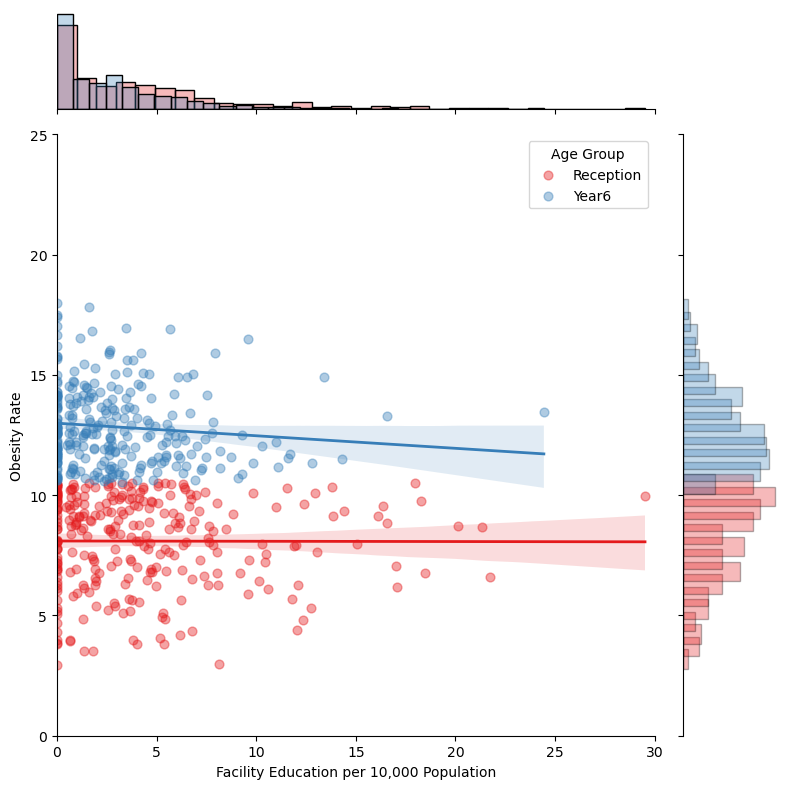

In [10]:
# List of yearly facility education columns  
education_cols = [  
    'facility_education_per_10000pop_2011',  
    'facility_education_per_10000pop_2012',  
    'facility_education_per_10000pop_2013',  
    'facility_education_per_10000pop_2014'  
]  

# List of yearly obesity columns (adjust according to your actual df)  
obesity_cols = [  
    'obese_recp_2008_2011',  
    'obese_recp_2009_2012',  
    'obese_recp_2010_2013',  
    'obese_recp_2011_2014',  
]  

# Create a new DataFrame to avoid modifying original  
plot_df = wards_master_df.copy()  

# Calculate average facility education across years  
plot_df['facility_education'] = plot_df[education_cols].mean(axis=1)  

# Calculate average obesity across years  
plot_df['obesity'] = plot_df[obesity_cols].mean(axis=1)  

# Define a median split age group based on obesity  
plot_df['age_group'] = np.where(  
    plot_df['obesity'] > plot_df['obesity'].median(),  
    'Year6',  
    'Reception'  
)  

# Filter relevant columns and drop rows with missing data  
plot_df = plot_df[['facility_education', 'obesity', 'age_group']].dropna()  

# Apply thresholds for cleaner plotting  
plot_df = plot_df[  
    (plot_df['facility_education'] >= 0) & (plot_df['facility_education'] <= 30) &  
    (plot_df['obesity'] >= 0) & (plot_df['obesity'] <= 25)  
]  

# Initialize JointGrid for scatter + marginal distributions  
g = sns.JointGrid(data=plot_df, x='facility_education', y='obesity', height=8)  

palette = sns.color_palette("Set1", n_colors=2)  
groups = plot_df['age_group'].unique()  

# Plot scatter points and regression lines by age group on main axes  
for idx, group in enumerate(groups):  
    subset = plot_df[plot_df['age_group'] == group]  
    sns.regplot(  
        x='facility_education', y='obesity', data=subset,  
        scatter=True, fit_reg=True,  
        scatter_kws={'alpha': 0.4, 's': 40, 'color': palette[idx]},  
        line_kws={'color': palette[idx], 'linewidth': 2},  
        ax=g.ax_joint, label=group  
    )  

# Plot marginal histograms of facility education on top  
for idx, group in enumerate(groups):  
    subset = plot_df[plot_df['age_group'] == group]  
    sns.histplot(subset['facility_education'], color=palette[idx], alpha=0.3, bins=30, ax=g.ax_marg_x)  

# Plot rotated horizontal bar charts for obesity distribution on the right  
bin_edges = np.linspace(plot_df['obesity'].min(), plot_df['obesity'].max(), 30)  
for idx, group in enumerate(groups):  
    subset = plot_df[plot_df['age_group'] == group]  
    counts, _ = np.histogram(subset['obesity'], bins=bin_edges)  
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  
    g.ax_marg_y.barh(bin_centers, counts, color=palette[idx], alpha=0.3, edgecolor='black')  

# Synchronize axis limits  
g.ax_joint.set_xlim(0, 30)  
g.ax_joint.set_ylim(0, 25)  
g.ax_marg_y.set_ylim(g.ax_joint.get_ylim())  

# Add legend and axis labels  
g.ax_joint.legend(title='Age Group')  
g.set_axis_labels('Facility Education per 10,000 Population', 'Obesity Rate')  

plt.tight_layout()  
plt.show()  

## 5. Methodology

[[ go back to the top ]](#Table-of-contents)

Following [Nau et al. (2019)](#nau-2019), this study analyses childhood obesity across London wards from 2010 to 2014 using panel data integrating socioeconomic and built environment variables. We develop age-specific fixed effects regression models at a fine ward-level scale, incorporating detailed facility types, age groups (Reception and Year 6), and their interactions with socioeconomic status (SES). This framework enables comprehensive control over spatial and temporal heterogeneity, while also accounting for residual variation and inherent spatial risk (see [Figure 1](#figure-1)).  

### 5.1 Multicollinearity Testing  

Multicollinearity is first assessed using Variance Inflation Factor (VIF) and Pearson correlation matrix to avoid high correlations among independent variables that may bias model estimation ([Hair et al., 2019](#hair-2019)):  
  - Variables with VIF > 5 are removed or transformed to ensure predictor independence.  
  - Variables with absolute Pearson correlation coefficients > 0.7 are excluded.  

This procedure ensures stability and interpretability of subsequent panel regression models.  

### 5.2 Cross-sectional OLS Regression

We conduct annual cross-sectional Ordinary Least Squares (OLS) regressions—a standard method estimating linear relationships—to assess baseline spatial associations between childhood obesity and variables. Treating years independently captures spatial variation but omits time-invariant unobserved factors.  

This approach provides important guidance on variable selection and model set-up for panel fixed effects models that address temporal dynamics and unobserved heterogeneity.  

### 5.3 Panel Fixed Effects Regression Model  

Based on the screened facility and socioeconomic variables, a panel fixed effects regression model is constructed using ward-level data from 2010 to 2014 to analyse spatial and temporal variations of childhood obesity rates. The fixed effects model effectively controls for time-invariant regional characteristics and annual uniform impacts, reducing omitted variable bias and improving causal inference robustness.  

The baseline model is expressed as follows:  

<div style="text-align:center; padding:10px 0;">  
<span style="font-family: 'Times New Roman', serif; font-size: 1.1em; font-weight: bold;">Obesity<sub>i,t</sub> = α + ∑<sub>k</sub> β<sub>k</sub> Facility<sub>k,i,t</sub> + γ<sub>1</sub> Unemployment<sub>i,t</sub> + γ<sub>2</sub> Greenspace<sub>i,t</sub> + γ<sub>3</sub> PTAL<sub>i,t</sub> + μ<sub>i</sub> + τ<sub>t</sub> + ε<sub>i,t</sub></span>  
</div>  

where:  

- <span style="font-family: 'Times New Roman', serif;">Obesity<sub>i,t</sub></span>: Childhood obesity rate of ward <span style="font-family: 'Times New Roman', serif;">i</span> in year <span style="font-family: 'Times New Roman', serif;">t</span>  
- <span style="font-family: 'Times New Roman', serif;">Facility<sub>k,i,t</sub></span>: Density of facility type <span style="font-family: 'Times New Roman', serif;">k</span> in ward <span style="font-family: 'Times New Roman', serif;">i</span> and year <span style="font-family: 'Times New Roman', serif;">t</span>  
- <span style="font-family: 'Times New Roman', serif;">Unemp<sub>i,t</sub></span>, <span style="font-family: 'Times New Roman', serif;">Greenspace<sub>i,t</sub></span>, <span style="font-family: 'Times New Roman', serif;">PTAL<sub>i,t</sub></span>: Control variables for unemployment rate, greenspace coverage, and public transport accessibility level respectively  
- <span style="font-family: 'Times New Roman', serif;">μ<sub>i</sub></span>: Ward fixed effects controlling for time-invariant regional characteristics  
- <span style="font-family: 'Times New Roman', serif;">τ<sub>t</sub></span>: Year fixed effects controlling for common annual shocks  
- <span style="font-family: 'Times New Roman', serif;">ε<sub>i,t</sub></span>: Error term  

Models are estimated separately for Reception (ages 4-5) and Year 6 (ages 10-11) groups to examine heterogeneous effects across developmental stages.  

Further, interaction terms between facility variables and socioeconomic status (SES) are incorporated:  

<div style="text-align:center; padding:10px 0;">  
<span style="font-family: 'Times New Roman', serif; font-size: 1.1em; font-weight: bold;">  
Obesity<sub>i,t</sub> = α + ∑<sub>k</sub> β<sub>k</sub> Facility<sub>k,i,t</sub> + ∑<sub>k</sub> δ<sub>k</sub> (Facility<sub>k,i,t</sub> × SES<sub>i,t</sub>) + γ<sub>1</sub> Unemployment<sub>i,t</sub> + γ<sub>2</sub> Greenspace<sub>i,t</sub> + γ<sub>3</sub> PTAL<sub>i,t</sub> + μ<sub>i</sub> + τ<sub>t</sub> + ε<sub>i,t</sub>  
</span>  
</div>  

which explores how SES moderates the impact of different facility types on childhood obesity, enhancing the policy relevance and scientific rigour of recommendations.  

### 5.4 Residuals and Spatial Heterogeneity Analysis  

Inspired by approaches combining spatial risk assessment with local variation analysis ([Walker et al., 2016](#walker-et-al-2016)), we leverage spatial fixed effects and residuals to capture inherent spatial risk across wards and unexplained local deviations under current government interventions. To apply this insight, we construct a two-dimensional quadrant plot classifying wards by spatial risk level and residual sign.  

This classification identifies:  

- **High spatial risk & positive residuals**: Persistent high-risk wards where obesity remains above expected levels, suggesting current interventions are insufficient.  
- **High spatial risk & negative residuals**: Wards with high inherent risk but better-than-expected outcomes, indicating effective local measures.  
- **Low spatial risk & positive residuals**: Wards usually at low risk but showing unexpected obesity increases, signalling emerging problems.  
- **Low spatial risk & negative residuals**: Wards with low risk and favourable outcomes, representing stable, well-managed areas.  

By combining spatial risk and residual deviations, this approach highlights where current strategies succeed or fail, guiding more precise resource allocation and multi-level public health actions.  
<a id="figure-1"></a>  
![Methodology flow chart](plots/methodology-flow-chart.png)  

<div style="text-align:center; padding:10px 0;">  
  <strong>Figure 1:</strong> Methodology flow chart.
</div>  

## 6. Results and discussion

[[ go back to the top ]](#Table-of-contents)

### 6.1 

Variance Inflation Factors (VIF):
                   Variable       VIF
0        facility_education  2.037713
1       facility_commercial  1.573460
2  facility_local_authority  1.449113
3              unemployment  3.592629
4                greenspace  3.324651
5                      ptal  4.200670


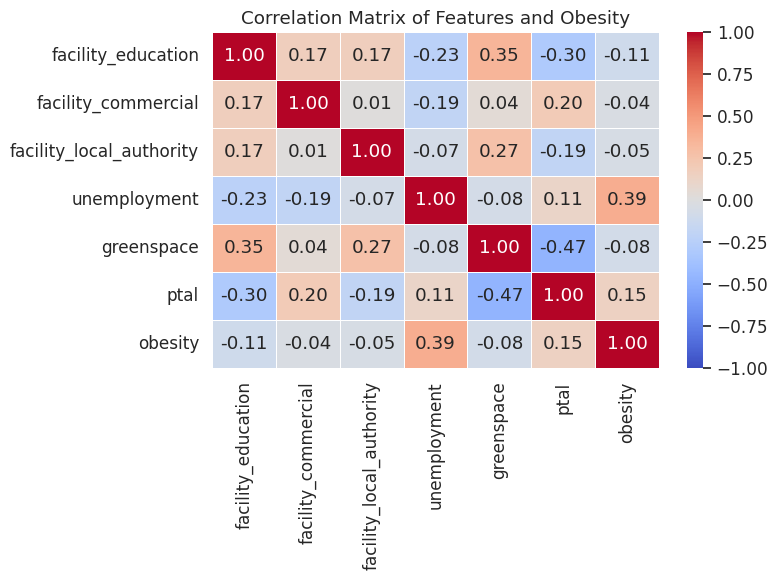

In [11]:
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  
from statsmodels.stats.outliers_influence import variance_inflation_factor  

# Define years and obesity columns per age group  
years = [2011, 2012, 2013, 2014]  
obesity_cols = {  
    'Reception': [f'obese_recp_{y-3}_{y}' for y in years],  
    'Year6': [f'obese_y6_{y-3}_{y}' for y in years],  
}  

# Panel variables of interest (facility and controls)  
panel_vars = [  
    'facility_education_per_10000pop_2011', 'facility_education_per_10000pop_2012',  
    'facility_education_per_10000pop_2013', 'facility_education_per_10000pop_2014',  
    'facility_commercial_per_10000pop_2011', 'facility_commercial_per_10000pop_2012',  
    'facility_commercial_per_10000pop_2013', 'facility_commercial_per_10000pop_2014',  
    'facility_local authority_per_10000pop_2011', 'facility_local authority_per_10000pop_2012',  
    'facility_local authority_per_10000pop_2013', 'facility_local authority_per_10000pop_2014',  
    'unemp_2011', 'unemp_2012', 'unemp_2013', 'unemp_2014',  
    'greenspace_pct_2011', 'greenspace_pct_2012', 'greenspace_pct_2013', 'greenspace_pct_2014',  
    'ptal_2011', 'ptal_2012', 'ptal_2013', 'ptal_2014'  
]  

# Prepare combined dataframe for VIF and correlation analysis  
data_all = pd.DataFrame()  

for group, cols in obesity_cols.items():  
    temp_df = pd.DataFrame()  
    for i, obesity_col in enumerate(cols):  
        year = years[i]  
        subset = wards_master_df[[  
            f'facility_education_per_10000pop_{year}',  
            f'facility_commercial_per_10000pop_{year}',  
            f'facility_local authority_per_10000pop_{year}',  
            f'unemp_{year}',  
            f'greenspace_pct_{year}',  
            f'ptal_{year}',  
            obesity_col  
        ]].copy()  
        # Rename columns for consistency  
        subset.columns = [  
            'facility_education', 'facility_commercial', 'facility_local_authority',  
            'unemployment', 'greenspace', 'ptal', 'obesity'  
        ]  
        subset['age_group'] = group  
        subset['year'] = year  
        temp_df = pd.concat([temp_df, subset], axis=0)  
    data_all = pd.concat([data_all, temp_df], axis=0)  

# Drop rows with missing values for analysis  
data_clean = data_all.dropna()  

# Select numeric variables for analysis  
features = ['facility_education', 'facility_commercial', 'facility_local_authority', 'unemployment', 'greenspace', 'ptal']  

# Calculate Variance Inflation Factor (VIF) to check multicollinearity  
X = data_clean[features].values  
vif_data = pd.DataFrame()  
vif_data['Variable'] = features  
vif_data['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]  

print("Variance Inflation Factors (VIF):")  
print(vif_data)  

# Compute correlation matrix including obesity  
corr_features = features + ['obesity']  
corr_matrix = data_clean[corr_features].corr()  

# Plot correlation heatmap  
sns.set_theme(style='whitegrid', font_scale=1.1)  
plt.figure(figsize=(8, 6))  
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)  
plt.title("Correlation Matrix of Features and Obesity")  
plt.tight_layout()  
plt.show()  

In [12]:
# Create a panel ("long") DataFrame: one row per ward per year  
panel_list = []  

years = [2011, 2012, 2013, 2014]  

for year in years:  
    prev_3y = year - 3  
    
    # Build the column names for this year (using your column name convention)  
    recp_col = f'obese_recp_{prev_3y}_{year}'  
    y6_col = f'obese_y6_{prev_3y}_{year}'  
    fac_edu = f'facility_education_per_10000pop_{year}'  
    fac_com = f'facility_commercial_per_10000pop_{year}'  
    fac_loc = f'facility_local authority_per_10000pop_{year}'  
    unemp_col = f'unemp_{year}'  
    green_col = f'greenspace_pct_{year}'  
    ptal_col = f'ptal_{year}'  

    # Select & rename  
    temp = wards_master_df[['GSS_CODE', 'NAME', 'BOROUGH', 'geometry', fac_edu, fac_com, fac_loc, unemp_col, green_col, ptal_col, recp_col, y6_col]].copy()  
    temp.columns = ['ward_code', 'ward_name', 'borough','geometry',    
                    'facility_education', 'facility_commercial', 'facility_local_authority',  
                    'unemployment', 'greenspace_pct', 'ptal',  
                    'obesity_reception', 'obesity_year6']  
    temp['year'] = year  
    panel_list.append(temp)  

# Concatenate data for all years  
panel_df = pd.concat(panel_list, axis=0).reset_index(drop=True)  

# Set panel index for panel regression (ward_code and year)  
panel_df = panel_df.set_index(['ward_code', 'year'])  

# Check result  
print(panel_df.info())  
print(panel_df.head())  

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 2616 entries, ('E05000405', np.int64(2011)) to ('E05009296', np.int64(2014))
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ward_name                 2616 non-null   object  
 1   borough                   2616 non-null   object  
 2   geometry                  2616 non-null   geometry
 3   facility_education        2481 non-null   float64 
 4   facility_commercial       2481 non-null   float64 
 5   facility_local_authority  2481 non-null   float64 
 6   unemployment              2280 non-null   float64 
 7   greenspace_pct            2280 non-null   float64 
 8   ptal                      2280 non-null   float64 
 9   obesity_reception         2240 non-null   float64 
 10  obesity_year6             2262 non-null   float64 
dtypes: float64(8), geometry(1), object(2)
memory usage: 254.1+ KB
None
                             war

In [13]:
panel_df_reset = panel_df.reset_index()  

years = sorted(panel_df_reset['year'].unique())  
models = []  
model_names = []  

for year in years:  
    sub = panel_df_reset[panel_df_reset['year'] == year]   
    model = smf.ols("obesity_year6 ~ facility_education + facility_commercial + facility_local_authority + unemployment + greenspace_pct + ptal", data=sub).fit()  
    models.append(model)  
    model_names.append(str(year))  

# Summarize the output table
table = summary_col(models, stars=True, model_names=model_names,  
                    info_dict={"N": lambda x: f"{int(x.nobs)}"},  
                    float_format="%.3f")  
print(table)  


                            2011      2012      2013      2014  
----------------------------------------------------------------
Intercept                12.759*** 13.216*** 13.480*** 14.293***
                         (0.729)   (0.754)   (0.723)   (0.739)  
facility_education       0.020     0.031     0.034     0.022    
                         (0.040)   (0.042)   (0.041)   (0.043)  
facility_commercial      0.046     0.054     0.058     0.034    
                         (0.045)   (0.046)   (0.044)   (0.046)  
facility_local_authority -0.056    -0.060    0.034     0.007    
                         (0.109)   (0.111)   (0.108)   (0.113)  
unemployment             0.007***  0.008***  0.009***  0.011*** 
                         (0.000)   (0.000)   (0.000)   (0.001)  
greenspace_pct           -0.006    -0.013    -0.010    -0.027** 
                         (0.010)   (0.010)   (0.010)   (0.011)  
ptal                     0.830***  0.770***  0.601***  0.546*** 
                        

## 7. Conclusion

[[ go back to the top ]](#Table-of-contents)

## References

[[ go back to the top ]](#Table-of-contents)

<a id="ayala-2021"></a>Ayala, G.X., et al., 2021. The social environment and childhood obesity. *International Journal of Environmental Research and Public Health*. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8365653/ [Accessed 20 Apr 2025].  

<a id="danielli-2021"></a>Danielli, A., Parker, L. and Swinburn, B., 2021. Systematic review into city interventions to address obesity. *International Journal of Environmental Research and Public Health*, 18(12). Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7910670/ [Accessed 20 Apr 2025].  

<a id="lieb-2009"></a>Lieb, D.C., 2009. Socioeconomic Factors in the Development of Childhood Obesity. *Current Obesity Reports*. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5596457/ [Accessed 20 Apr 2025].  

<a id="phe-2023"></a>Public Health England, 2023. London’s Local Health Profiles. London: Public Health England. Available at: https://fingertips.phe.org.uk/profile/health-profiles/data#page/4/gid/8000073/pat/15/par/E92000001/ati/6/are/E12000007/iid/90323/age/201/sex/4/cat/-1/ctp/-1/yrr/1/cid/4/tbm/1/page-options/car-do-0_tre-ao-0 [Accessed 20 Apr 2025].  

<a id="titis-2023"></a>Titis, E., 2023. Socio-economic correlates of childhood obesity in urban and rural England. *Public Health Nutrition*. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10478054/ [Accessed 20 Apr 2025].  

<a id="wyszynska-2020"></a>Wyszyńska, J., et al., 2020. Physical Activity in the Prevention of Childhood Obesity. *Frontiers in Pediatrics*. Available at: https://www.frontiersin.org/articles/10.3389/fped.2020.535705/full [Accessed 20 Apr 2025].  

<a id="yuan-2024"></a>Yuan, Y., 2024. Public health interventions against childhood obesity in China and globally. *Preventive Medicine Reports*, 29. Available at: https://www.sciencedirect.com/science/article/pii/S2468266724002457 [Accessed 20 Apr 2025].

London Data Store (2011). *Statistical GIS Boundary Files for London*. Available at: [https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london) (Accessed: 16 April 2025). <a name="lds-boundary"></a>

London Data Store (2023). *Ward Profiles and Atlas*. Available at: [https://data.london.gov.uk/dataset/ward-profiles-and-atlas](https://data.london.gov.uk/dataset/ward-profiles-and-atlas) (Accessed: 16 April 2025). <a name="ward-profiles-atlas"></a>

Office for National Statistics (ONS) (2023). *Ward Level Mid Year Population Estimates (Experimental)*. Available at: [https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental) (Accessed: 16 April 2025). <a name="ons-pop"></a>

Active Places Power (2023). *Active Places Dataset*. Available at: [https://www.activeplacespower.com/datasets/1e189022e7064e0e9b1bdaadef6d3b78/explore](https://www.activeplacespower.com/datasets/1e189022e7064e0e9b1bdaadef6d3b78/explore) (Accessed: 16 April 2025). <a name="active-places-power"></a>

Li, J., Heap, A. D., Potter, A., & Daniell, J. (2014). Spatial interpolation methods applied in the environmental sciences: A review. *Environmental Modelling & Software*, 53, pp.182–190. https://doi.org/10.1016/j.envsoft.2013.12.008 <a name="li-2014"></a>  

<a id="hair-2019"></a>Hair, J. F., Black, W. C., Babin, B. J., & Anderson, R. E. (2019). *Multivariate Data Analysis* (8th Edition). Cengage Learning.  

<a id="nau-2019"></a>Nau, C., Ellis, H., Huang, H., et al. (2019). Multidimensional Socioeconomic and Built Environment Factors and Their Associations with Youth Body Mass Index Trajectories across Geographically Heterogeneous Communities. *Preventive Medicine Reports*, 15, 100939. https://doi.org/10.1016/j.pmedr.2019.100939  

<a id="walker-et-al-2016"></a>Walker, P. G. T., et al. (2016). Estimating the most efficient allocation of interventions to reduce malaria burden and transmission. *The Lancet Global Health*, 4(7), e474-e484. Available at: [https://www.thelancet.com/journals/langlo/article/PIIS2214-109X(16)30073-0/fulltext](https://www.thelancet.com/journals/langlo/article/PIIS2214-109X(16)30073-0/fulltext) [Accessed 27 April 2025].  

In [79]:
class HideCodePreprocessor(Preprocessor):  
    """  
    Preprocessor to hide code or output based on cell metadata.  
    
    Usage in notebook:  
    - Add metadata to cell:   
      {"tags": ["hide-code"]} or {"tags": ["hide-output"]}  
    """  
    def preprocess_cell(self, cell, resources, index):  
        # Check cell metadata for hiding instructions  
        tags = cell.metadata.get('tags', [])  
        
        if 'hide-code' in tags and cell.cell_type == 'code':  
            # Add class to hide code  
            cell.cell_type = 'markdown'  
            cell.source = ''  
        
        if 'hide-output' in tags and cell.cell_type == 'code':  
            # Clear outputs for this cell  
            cell.outputs = []  
            cell.metadata['hide_output'] = True  
        
        return cell, resources  

def convert_notebook_to_pdf(  
    notebook_path,   
    output_path=None,   
    hide_code_tags=['hide-code'],  
    hide_output_tags=['hide-output']  
):  
    """  
    Convert Jupyter Notebook to PDF with advanced hiding capabilities.  
    
    Args:  
        notebook_path (str): Path to the notebook file  
        output_path (str, optional): Custom output PDF path  
        hide_code_tags (list): Tags to identify cells with code to hide  
        hide_output_tags (list): Tags to identify cells with output to hide  
    
    Returns:  
        str: Path to the generated PDF file  
    """  
    # Set default output path  
    if output_path is None:  
        output_path = notebook_path.replace('.ipynb', '.pdf')  
    
    # Custom CSS with hiding capabilities  
    css_content = '''  
 
    @page {  
        size: A4;  
        margin: 2cm 1cm 2cm 1cm;  
    }  
    
    body {  
        font-family: Arial, sans-serif;  
        line-height: 1.6;  
        width: 100%;  
        max-width: 680px;  
        margin: 0 0 0 -80px;  
        padding: 20px;  
    }  
    
    .rendered_html {  
        width: 100%;  
        margin: 0;  
        padding: 0;  
    }  
    
    pre {   
        background-color: #f4f4f4;
        white-space: pre-wrap; 
        max-width: 100%; 
        width: 800px; 
        overflow-x: auto;   
        border: 1px solid #e0e0e0; 
        margin-left: -50px;
    }  
    
    table {  
        width: 100%;  
        border-collapse: collapse;  
        margin: 10px 0;  
    }  
    
    code {   
        background-color: #f1f1f1;   
        padding: 2px 2px;   
        border-radius: 3px;   
        font-size: 0.9em; 
        display: inline-block;   
    }  

    .output_area, .input_area {  
        width: 100%;  
        overflow-x: auto;  
    }  
    
    /* Hide code block */  
    .hidden-code,  
    .hidden-code pre,  
    .input_area.hidden-code {  
        display: none !important;  
        visibility: hidden;  
        height: 0;  
        width: 0;  
        overflow: hidden;  
    }  
    
    /* Hide output block */  
    .hidden-output,  
    .output_area.hidden-output,  
    .output_area .hidden-output {  
        display: none !important;  
        visibility: hidden;  
        height: 0;  
        width: 0;  
        overflow: hidden;  
    }  
     
    '''  
    
    # Write CSS to file  
    with open('notebook_pdf.css', 'w', encoding='utf-8') as f:  
        f.write(css_content)  
    
    # Configure HTML exporter with custom preprocessor  
    html_exporter = HTMLExporter()  
    html_exporter.template_name = 'classic'  
    html_exporter.register_preprocessor(HideCodePreprocessor, enabled=True)  
    
    # Export notebook to HTML  
    body, _ = html_exporter.from_filename(notebook_path)  
    
    # Generate temporary HTML file  
    html_path = notebook_path.replace('.ipynb', '.html')  
    with open(html_path, 'w', encoding='utf-8') as f:  
        f.write(body)  
    
    # Convert HTML to PDF  
    HTML(html_path).write_pdf(  
        output_path,   
        stylesheets=['notebook_pdf.css']  
    )  
    
    print(f"✅ PDF conversion successful: {output_path}")  
    return output_path  

# Usage example  
convert_notebook_to_pdf('24109799_submission_CASA0006.ipynb')  

✅ PDF conversion successful: 24109799_submission_CASA0006.pdf


'24109799_submission_CASA0006.pdf'